Convert DICOM to PNG
Version 1:

Keep aspect ratio
16 bits PNG
1024 largest dimension

In [1]:
import pandas as pd
import numpy as np
import math, random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import pydicom
import cv2
import json
from PIL import Image

In [2]:
!pip install -qU python-gdcm pydicom pylibjpeg

You should consider upgrading via the '/Users/ppujari/Applications/anaconda3/envs/hugging_face/bin/python -m pip install --upgrade pip' command.


In [2]:
IMAGE_SIZE_H, IMAGE_SIZE_W = 1024, 1024
DICOM_IMAGES = "./images"

In [3]:
print('Pydicom:', pydicom.__version__)

Pydicom: 2.3.1


In [4]:
files = glob.glob(DICOM_IMAGES + "/*.dcm")
print(len(files), files[:10])

4 ['./images/1864590858.dcm', './images/462822612.dcm', './images/1874946579.dcm', './images/1459541791.dcm']


In [5]:
dicom = pydicom.dcmread(files[0])
new_image = dicom.pixel_array.astype(float)
scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0
scaled_image = np.uint8(scaled_image)
final_image = Image.fromarray(scaled_image)

In [6]:
final_image.show()

In [7]:
def image_resize_keep_ar(image, width = None, height = None, inter = cv2.INTER_LINEAR):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

In [8]:
def read_dicom_as_image(dcm_file, resize=True, keep_ar=True):
    dicom = pydicom.dcmread(dcm_file)
    image = dicom.pixel_array  
    image = (image - image.min()) / (image.max() - image.min() + 1e-6)  # Float64
    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        image = 1 - image
    if resize is True:
        if keep_ar is True:
            h, w = image.shape
            if w > h:
                 image = image_resize_keep_ar(image, width = IMAGE_SIZE_W)
            else:
                 image = image_resize_keep_ar(image, height = IMAGE_SIZE_H)
        else:
            image = cv2.resize(image, (IMAGE_SIZE_H, IMAGE_SIZE_W), interpolation=cv2.INTER_LINEAR)
    return image

In [9]:
def save_dicom_as_array(dcm_file, resize=True, with_image=True):
    dimg = read_dicom_as_image(dcm_file, resize=resize) # np.array Float64 - 0.0 / 1.0
    patient_id = dcm_file.split('/')[-2]
    image_id   = dcm_file.split('/')[-1][:-4]
    filename = patient_id + "_" + image_id    
    if with_image is True:
        dimg = (dimg * 65535).astype(np.uint16)
        cv2.imwrite(DICOM_IMAGES + filename + ".png", dimg)
    else:
        np.savez(DICOM_IMAGES + filename + ".npz", img=dimg.astype(np.float32))
    return filename

### Display one image

In [10]:
files = glob.glob(DICOM_IMAGES + "/*.dcm")
print(len(files), files[:10])

4 ['./images/1864590858.dcm', './images/462822612.dcm', './images/1874946579.dcm', './images/1459541791.dcm']


In [11]:
dimg = read_dicom_as_image(files[0])
files[0], dimg.shape, dimg.min(), dimg.max(), dimg.mean(), dimg.dtype

('./images/1864590858.dcm',
 (1024, 939),
 6.211180458848276e-10,
 0.9766832007209867,
 0.09705645279085863,
 dtype('float64'))

In [12]:
filename = save_dicom_as_array(files[0])

In [13]:
pimg = cv2.imread(DICOM_IMAGES + filename + ".png", -cv2.IMREAD_ANYDEPTH)
filename, pimg.shape, pimg.min(), pimg.max(), pimg.mean(), pimg.dtype

('images_1864590858',
 (1024, 939),
 0,
 64006,
 6360.508379301451,
 dtype('uint16'))

In [14]:
diff = dimg - (pimg/65535.)
filename, diff.shape, diff.min(), diff.max(), diff.mean(), diff.dtype

('images_1864590858',
 (1024, 939),
 1.701094820560911e-11,
 1.5258882547608543e-05,
 1.3161569767171127e-06,
 dtype('float64'))

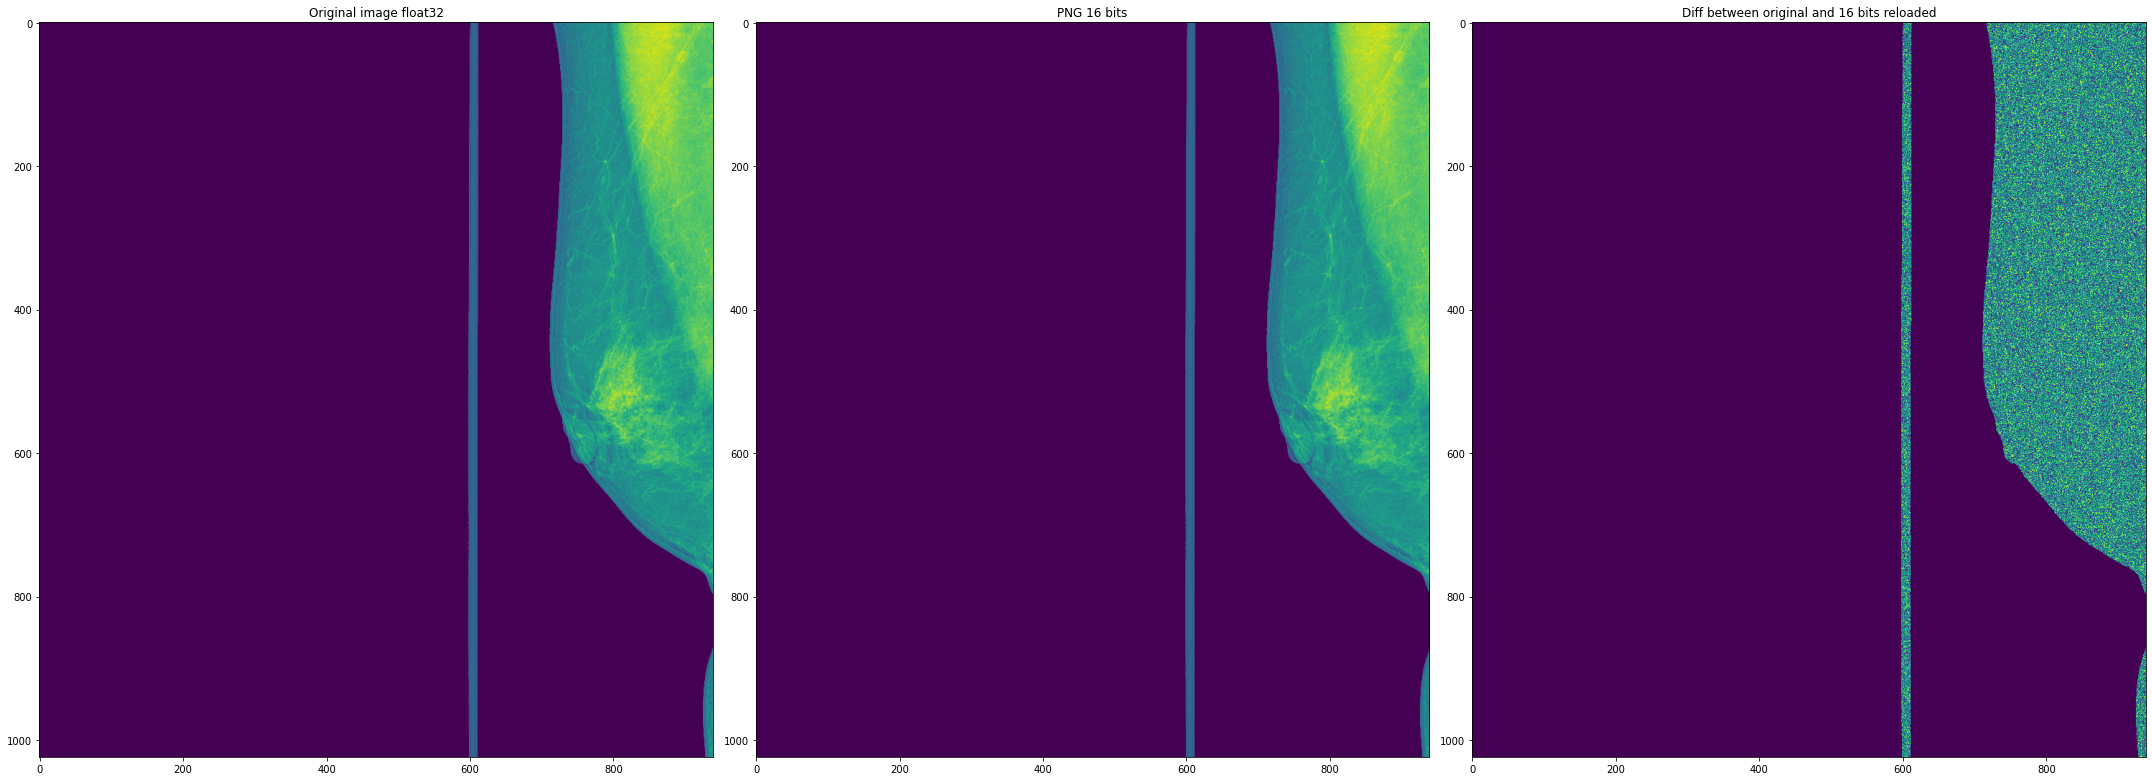

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15))
d = ax[0].imshow(dimg)
d = ax[0].set_title("Original image float32")
d = ax[1].imshow(pimg)
d = ax[1].set_title("PNG 16 bits")
d = ax[2].imshow(diff)
d = ax[2].set_title("Diff between original and 16 bits reloaded")
plt.tight_layout()
plt.show()


In [ ]:
filename = save_dicom_as_array(files[0])